#  **Natural Language Inferencing (NLI)**
1. NLI is a classic NLP (Natural Language Processing) problem that involves taking two sentences (the premise and the hypothesis ), and deciding how they are related- if the premise entails the hypothesis, contradicts it, or neither.
2. [ViNLI](https://aclanthology.org/2022.coling-1.339/): A Vietnamese Corpus for Studies on Open-Domain Natural Language Inference
     * ViNLI comprises over 30,000 human-annotated premise-hypothesis sentence pairs extracted from more than 800 online news articles on 13 distinct topics. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uit-vinli/UIT_ViNLI_1.0_train.jsonl
/kaggle/input/uit-vinli/UIT_ViNLI_1.0_dev.jsonl
/kaggle/input/uit-vinli/UIT_ViNLI_1.0_test.jsonl


In [2]:
import json
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Load Dataset**

In [3]:
train = pd.read_json('/kaggle/input/uit-vinli/UIT_ViNLI_1.0_train.jsonl', lines=True)
dev = pd.read_json('/kaggle/input/uit-vinli/UIT_ViNLI_1.0_dev.jsonl', lines=True)
test = pd.read_json('/kaggle/input/uit-vinli/UIT_ViNLI_1.0_test.jsonl', lines=True)

In [4]:
col = ['sentence1', 'sentence2', 'gold_label']
train = train[col]
dev = dev[col]
test = test[col]
train = train.rename(columns={'gold_label': 'label'})
dev = dev.rename(columns={'gold_label': 'label'})
test = test.rename(columns={'gold_label': 'label'})

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24376 entries, 0 to 24375
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence1  24376 non-null  object
 1   sentence2  24376 non-null  object
 2   label      24376 non-null  object
dtypes: object(3)
memory usage: 571.4+ KB


# **Visualize**

In [6]:
import plotly.express as px
# Calculate label frequencies for each set
train_labels, train_frequencies = train["label"].value_counts().index, train["label"].value_counts().values
test_labels, test_frequencies = test["label"].value_counts().index, test["label"].value_counts().values
dev_labels, dev_frequencies = dev["label"].value_counts().index, dev["label"].value_counts().values

# Create separate pie charts for each set using Plotly Express
fig_train = px.pie(values=train_frequencies,
                   names=train_labels,
                   title='Train Set: Label Distribution',
                   color_discrete_sequence=px.colors.sequential.Plotly3)

fig_test = px.pie(values=test_frequencies,
                  names=test_labels,
                  title='Test Set: Label Distribution',
                  color_discrete_sequence=px.colors.sequential.Plotly3)

fig_dev = px.pie(values=dev_frequencies,
                 names=dev_labels,
                 title='Dev Set: Label Distribution',
                 color_discrete_sequence=px.colors.sequential.Plotly3)

# Show the plots
fig_train.show()
fig_test.show()
fig_dev.show()

# **Tokenizer**

In [7]:
from transformers import AutoTokenizer, XLMRobertaModel, TrainingArguments, Trainer, DataCollatorWithPadding, TFAutoModel, AutoModelForSequenceClassification, AutoConfig
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score
from datasets import load_metric
import numpy as np

In [8]:
# model_name = 'symanto/xlm-roberta-base-snli-mnli-anli-xnli'
model_name = 'xlm-roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [9]:
label2id = {
    "0": "contradiction",
    "1": "neutral",
    "2": "entailment",
    "3": "other"
}
config = AutoConfig.from_pretrained(model_name)
id2label = {y:x for x,y in label2id.items()}
config.label2id = label2id
config.id2label = id2label
config.num_labels = 4

In [10]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, config = config)

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
config = model.config

# **DatasetDict**

In [12]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

train['label'] = train['label'].astype(str)
test['label'] = test['label'].astype(str)
replace_dict = {'neutral': '1', 'entailment': '2', 'contradiction': '0', 'other': '3'}
train['label'].replace(replace_dict, inplace=True)
test['label'].replace(replace_dict, inplace=True)
test = test[test['label'] != '-']
train['label'] = train['label'].astype(int)
test['label'] = test['label'].astype(int)

train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test)

ds = DatasetDict()
ds['train'] = train_ds
ds['validation'] = val_ds
ds['test'] = test_ds

In [13]:
def tokenizer_sentence(data):
    return tokenizer(data['sentence1'], data['sentence2'], truncation=True)
tokenized_ds = ds.map(tokenizer_sentence, batched=True)
tokenized_ds

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 19500
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 4876
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 2991
    })
})

In [14]:
test_ds = test_ds.map(tokenizer_sentence, batched=True)

  0%|          | 0/3 [00:00<?, ?ba/s]

In [15]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# **Modeling(XLM-Roberta large)**

In [16]:
from transformers.modeling_utils import PreTrainedModel
class CustomXLMRobertaModel(PreTrainedModel):
    def __init__(self, num_labels, config):
        super(CustomXLMRobertaModel, self).__init__(config)
        self.roberta = XLMRobertaModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(1024, num_labels)
        self.loss = nn.CrossEntropyLoss()
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        output = self.dropout(output.pooler_output)
        logits = self.classifier(output)

        if labels is not None:
            loss = self.loss(logits.view(-1, self.num_labels), labels.view(-1))
            return {"loss": loss, "logits": logits}
        else:
            return logits
model = CustomXLMRobertaModel(num_labels=4, config = config)

In [17]:
training_args = TrainingArguments("/content",
                                  optim="adamw_torch",
                                  num_train_epochs=2,
                                  evaluation_strategy="epoch",
                                  logging_dir='./logs',
                                  logging_steps=10,
                                  report_to="none",
                                  learning_rate = 1e-5,
                                  per_device_train_batch_size = 16,
                                  per_device_eval_batch_size = 16
                        )
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': load_metric("f1").compute(predictions=predictions, references=labels, average="micro")
    }

In [18]:
trainer = Trainer(
    model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
model.summary()

# **Training**

In [19]:
!pip install wandb
import os
os.environ["WANDB_DISABLED"] = "false"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [20]:
trainer.train()

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.447700,0.441236,0.841674,{'f1': 0.841673502871206}
2,0.300700,0.412597,0.861157,{'f1': 0.8611566858080394}


TrainOutput(global_step=2438, training_loss=0.5284101993358947, metrics={'train_runtime': 1702.991, 'train_samples_per_second': 22.901, 'train_steps_per_second': 1.432, 'total_flos': 7529794192831104.0, 'train_loss': 0.5284101993358947, 'epoch': 2.0})

In [21]:
trainer.save_model("/kaggle/working/")

In [22]:
# loaded_model = AutoModelForSequenceClassification.from_pretrained('/kaggle/working/')

# **Plot accuracy**

In [33]:
test_predictions = trainer.predict(test_ds)
test_logits = torch.from_numpy(test_predictions.predictions)
test_probs = torch.softmax(test_logits, -1).tolist()
outputs = []
for index, prob in enumerate(test_probs):
    predicted_label = prob.index(max(prob))
    outputs.append(predicted_label)
results = []
for i in test['label']:
    results.append(i)


In [41]:
len(outputs)

2991

In [45]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
accuracy = accuracy_score(results, outputs)
print("Testing on test set: ",accuracy)

Testing on test set:  0.8458709461718489


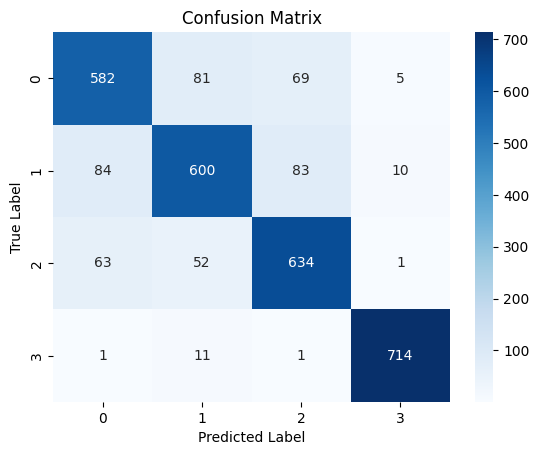

In [38]:
conf_matrix = confusion_matrix(results, outputs)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# **Testing input sentence**

In [23]:
import torch

In [24]:
def test_sentences(sentence1, sentence2, tokenizer_sentence, trainer):
    test_data = pd.DataFrame(data = {'sentence1': [sentence1, 'temp'], 'sentence2': [sentence2, 'temp']})
    test_dataset = Dataset.from_pandas(test_data) 
    test = test_dataset.map(tokenizer_sentence, batched=True)
    predictions = trainer.predict(test)
    logits = torch.from_numpy(predictions.predictions)
    probs = torch.softmax(logits, -1).tolist()
    result = {}
    label_mapping = {'neutral': 1, 'entailment': 2, 'contradiction': 0, 'other': 3}
    for index, prob in enumerate(probs):
        if index == 0:
            predicted_label = prob.index(max(prob))
            element_id = test[index]
            labels = ['contradiction', 'neutral', 'entailment', 'other']
            result = {
                'sentence1': test_data['sentence1'][index],
                'sentence2': test_data['sentence2'][index],
                'predicted_label': labels[predicted_label]}
            return result

In [25]:
sentence1 = input("Enter the first sentence: ")
sentence2 = input("Enter the second sentence: ")
result_df = test_sentences(sentence1, sentence2, tokenizer_sentence, trainer)
print(result_df)

Enter the first sentence:  có
Enter the second sentence:  không


  0%|          | 0/1 [00:00<?, ?ba/s]

{'sentence1': 'có', 'sentence2': 'không', 'predicted_label': 'neutral'}
